In [1]:
import random
import numpy as np, skimage, skimage.io, pylab, skimage.filters, scipy, scipy.signal 
import matplotlib.pyplot as plt
import cv2


# Stereo matching


In [2]:
%pylab inline

src1=skimage.io.imread('/Users/Hasan/Desktop/Workspace/Computer_Vision/Project2/im0.png')
src2=skimage.io.imread('/Users/Hasan/Desktop/Workspace/Computer_Vision/Project2/im1.png')

R=skimage.img_as_float(src1) 
L=skimage.img_as_float(src2)

#R = np.zeros((RR.shape[0], RR.shape[1]))
#L = np.zeros((LL.shape[0], LL.shape[1]))

# converting RGB to single color values:
'''
for i in range(0, RR.shape[0]):
    for j in range(0, RR.shape[1]):
            R[i][j] = (0.2126*(RR[i][j][0])) + (0.7152*(RR[i][j][1])) + (0.0722*(RR[i][j][2]))

for i in range(0, LL.shape[0]):
    for j in range(0, LL.shape[1]):
            L[i][j] = (0.2126*(LL[i][j][0])) + (0.7152*(LL[i][j][1])) + (0.0722*(LL[i][j][2]))
'''
#pylab.imshow(L)


Populating the interactive namespace from numpy and matplotlib


/Users/Hasan/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'\nfor i in range(0, RR.shape[0]):\n    for j in range(0, RR.shape[1]):\n            R[i][j] = (0.2126*(RR[i][j][0])) + (0.7152*(RR[i][j][1])) + (0.0722*(RR[i][j][2]))\n\nfor i in range(0, LL.shape[0]):\n    for j in range(0, LL.shape[1]):\n            L[i][j] = (0.2126*(LL[i][j][0])) + (0.7152*(LL[i][j][1])) + (0.0722*(LL[i][j][2]))\n'

In [3]:
print L.shape
print R.shape

dLimit = L.shape[0]/3
print dLimit

(198, 288, 3)
(198, 288, 3)
66


# Calculating Disparities

In [32]:
import math 
                # 1984   , 2888      , 661
DSI = np.empty((L.shape[0], L.shape[1], dLimit))    
altDSI = np.empty((L.shape[0], L.shape[1], dLimit)) 

count = 0
for i in range (0, DSI.shape[0]): 
    for j in range (0, DSI.shape[1]):
        
       
        #print 'i:', i, 'j: ', j
        
        for k in range (0, DSI.shape[2]):
            
            #shift = min ((j+k), 288)
            altShift = max ((j-k), 0)
            shift = min ((j+k), 287)
            
            
            Red = (L[i][j][0] - R[i][shift][0])**2  
            Green = (L[i][j][1] - R[i][shift][1])**2  
            Blue = (L[i][j][2] - R[i][shift][2])**2
            
            #this works!
            altRed = (R[i][j][0] - L[i][altShift][0])**2  
            altGreen = (R[i][j][1] - L[i][altShift][1])**2  
            altBlue = (R[i][j][2] - L[i][altShift][2])**2
        
            SOS = Red+Green+Blue
            altSOS = altRed+altGreen+altBlue
            DSI[i][j][k] = SOS
            altDSI[i][j][k] = altSOS
                    
            

# Gaussian and Bilateral Filtering

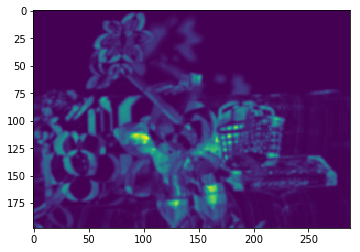

In [33]:
import skimage
import cv2

sig = 2

for k in range (0, DSI.shape[2]):
    
    #g = DSI[:,:,k] 
    #f = altDSI[:,:,k]
    
    #gauss = skimage.filters.gaussian(g, sigma = sig)
    #gauss2 = skimage.filters.gaussian(f, sigma = sig)
    
    color = 25
    space = 1
    diam = 10
    
    g = np.float32(DSI[:,:,k])
    f = np.float32(altDSI[:,:,k])
    
    bilat = cv2.bilateralFilter(src = g, d = diam, sigmaColor = color , sigmaSpace = space) 
    bilat2 = cv2.bilateralFilter(src = f, d = diam, sigmaColor = color , sigmaSpace = space) 
    
    DSI[:,:,k] = bilat
    altDSI[:,:,k] = bilat2
    
pylab.imshow(DSI[:,:,20])
    

# Finding minimum disparaities 

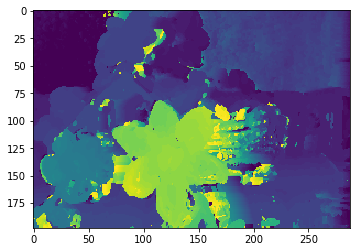

In [34]:

DSImap = np.empty((L.shape[0], L.shape[1])) 
altDSImap = np.empty((L.shape[0], L.shape[1])) 
                        
minD = 9999

                        
for i in range (0, DSI.shape[0]): 
    for j in range (0, DSI.shape[1]):
            
        minD = 9999
        depth = 0
        
        altminD = 9999
        altdepth = 0
        
        for k in range (0, DSI.shape[2]):
            
            curr = DSI[i][j][k]
             
            if (curr < minD):
                minD = curr
                depth = k
                
        for k in range (0, DSI.shape[2]):
            
            altcurr = altDSI[i][j][k]
             
            if (altcurr < altminD):
                altminD = altcurr
                altdepth = k
                
        DSImap [i][j] = depth
        altDSImap [i][j] = altdepth
                        
pylab.imshow(DSImap)
                    
        

# RMS Calculation

In [35]:
# RMS calculation

truth = numpy.load('/Users/Hasan/Desktop/gt.npy')
RMS = 0
altRMS = 0

for i in range (0, DSImap.shape[0]): 
    for j in range (0, DSImap.shape[1]):
        RMS += (DSImap[i][j] - truth[i][j])**2
        altRMS += (altDSImap[i][j] - truth[i][j])**2

RMS = (RMS / (DSImap.shape[0]*DSImap.shape[1]))**(0.5)
altRMS = (altRMS / (altDSImap.shape[0]*altDSImap.shape[1]))**(0.5)

print 'RMS value w/d =', diam, ', colorSigma =', color,', colorSpace =', space,', is: ', RMS
print 'altRMS value w/d =', diam, ', colorSigma =', color,', colorSpace =', space,', is: ', altRMS


RMS value w/d = 10 , colorSigma = 25 , colorSpace = 1 , is:  18.6167011498
altRMS value w/d = 10 , colorSigma = 25 , colorSpace = 1 , is:  11.6392746917


# Left-Right Check

(198, 288)
(198, 288)


/Users/Hasan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


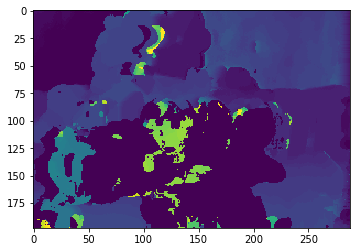

In [8]:
#Left right check

print altDSImap.shape
print DSImap.shape

occluded = np.empty((L.shape[0], L.shape[1])) 

for i in range (0, altDSImap.shape[0]): 
    for j in range (0, altDSImap.shape[1]):
                
            if (abs(altDSImap[i][j] - DSImap[i][min(j+altDSImap[i][j], altDSImap.shape[1]-1)]) < 15):
                #print 'i:, ', i, ' j: ', j,', occlusion!'
                occluded[i][j] = DSImap[i][j]  
            else:
                occluded[i][j] = 0 
                
            
pylab.imshow(occluded)


# ------------------------------HOMOGRAPHIES ----------------------------------------



In [9]:
A = cv2.imread('/Users/Hasan/Desktop/Workspace/Computer_Vision/Project2/rschool.jpg')
B = cv2.imread('/Users/Hasan/Desktop/Workspace/Computer_Vision/Project2/lschool.jpg')

# Calculating keypoints and descriptors

In [10]:

print 'A shape:', A.shape
print 'B shape:', B.shape

sift = cv2.xfeatures2d.SIFT_create()

kpA, desA = sift.detectAndCompute(A,None)
kpB, desB = sift.detectAndCompute(B,None)

#print kp1.dtype
print 'desA shape:', desA.shape
print 'desB shape:',desB.shape
print kpA[1].pt

bf = cv2.BFMatcher()
matches = bf.knnMatch(desA,desB, k=2)

#print 'matches: ', matches

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

#print 'good: ', good

print 'good shape:', len(good)
print 'match shape:', len(good[1])

print ' x1, y1: ', kpA[good[1][0].queryIdx].pt
print ' x2, y2: ', kpB[good[1][0].trainIdx].pt

    
#pylab.imshow()








A shape: (402, 602, 3)
B shape: (402, 602, 3)
desA shape: (1088, 128)
desB shape: (1043, 128)
(63.35419845581055, 269.8349304199219)
good shape: 253
match shape: 1
 x1, y1:  (588.977783203125, 277.5233154296875)
 x2, y2:  (229.2913818359375, 245.58721923828125)


# Calculating Homographies

In [11]:
def homog(originalC, mappedC):
    
    A = np.empty([8,8])
    y = np.empty([8,1])
    
    for i in range(0, 4):
        (xa,ya) = originalC[i]
        (xb,yb) = mappedC[i]
        
        A[i*2][:] = [-xb, -yb, -1, 0, 0, 0, xa*xb, xa*yb]
        A[(i*2)+1][:] = [0,0,0,-xb,-yb,-1,ya*xb,ya*yb]
        
        y[i*2][0] = -xa
        y[(i*2)+1][0] = -ya
    
    #print 'Matrix A: '
    #print A
    
    params = np.linalg.lstsq(A, y)
    
    H = np.array([  [params[0][0][0], params[0][1][0], params[0][2][0]],
                    [params[0][3][0], params[0][4][0], params[0][5][0]], 
                    [params[0][6][0], params[0][7][0], 1]])
    
    H = numpy.around(H, decimals=2)
    
    return H



# Applying homographies


In [12]:
def applyHomog (H, x, y):
    
    #print x, y
    xi = np.array([ [x], [y], [1] ])
    
    #print xi
    #print H
    
    #print H.dtype
    #print xi.dtype
    
    sol = np.matmul(np.asarray(H),np.asarray(xi))
    
    #print sol

    return sol[0][0], sol[1][0] 

# Testing Homographies

In [13]:

# fitting a homography:

originalC = [(0,0), (1, 0), (0, 1), (1, 1)]
mappedC = [(1, 2), (3, 2), (1, 4), (3, 4)]

hom =  homog(originalC, mappedC)

print "homography: ", hom


# applying a pre-made homography:

H = [[0.5, 0, -0.5], [0, 0.5, -1], [0, 0, 1]]

x = 4
y = 4

applyHomog (H, x, y)

#[(0, 0), (1, 0), (0, 1), (1, 1)], image B points [(1, 2), (3, 2), (1, 4), (3, 4)],
#( x1, y1, x1p, y1p, x2, y2, x2p, y2p, x3, y3, x3p, y3p, x4, y4, x4p, y4p):




homography:  [[ 0.5  0.  -0.5]
 [-0.   0.5 -1. ]
 [-0.   0.   1. ]]


(1.5, 1.0)

# RANSAC

In [14]:
import random

hom = 0
tDiff = 0
homographies = np.empty([len(good)-1, 3,3])
inlierArr = np.empty([len(good)-1])
threshold = 40000

for i in range (0, len(good)-1): 
        
        tDiff = 0
        currInliers = 0
        
        selection1 = random.sample(good, 1)
        selection2 = random.sample(good, 1)
        selection3 = random.sample(good, 1)
        selection4 = random.sample(good, 1)
        
        x1, y1 = kpA[selection1[0][0].queryIdx].pt
        x1p, y1p = kpB[selection1[0][0].trainIdx].pt     
        x2, y2 = kpA[selection2[0][0].queryIdx].pt
        x2p, y2p = kpB[selection2[0][0].trainIdx].pt      
        x3, y3 = kpA[selection3[0][0].queryIdx].pt
        x3p, y3p = kpB[selection3[0][0].trainIdx].pt       
        x4, y4 = kpA[selection4[0][0].queryIdx].pt
        x4p, y4p = kpB[selection4[0][0].trainIdx].pt
        
        originalC = [(x1,y1), (x2, y2), (x3, y3), (x4, y4)]
        mappedC = [(x1p,y1p), (x2p, y2p), (x3p, y3p), (x4p, y4p)]
        
        # calculating homogrpahy:
        
        H = homog (originalC, mappedC)
        
        # looping through all other good matches w/ this homography
        
        xDiff = 0 
        yDiff = 0     
        
        
        
        for j in range (0, len(good)-1):
            
            x,y = kpA[good[j][0].queryIdx].pt
            
            Tx,Ty = kpA[good[j][0].trainIdx].pt
            
            xp, yp = applyHomog (H, x, y)
            
            diff = ((Tx - xp)**2 + (Ty - yp)**2)/2
            
            #print 'Homography ', hom, '.Difference value for this match: ', diff
            
            tDiff +=diff
           
            
            if (diff < threshold ): 
                currInliers+=1
                     
        #print 'This homographies total difference value is: ', tDiff
        #print 'Homography', hom, ' has ', currInliers, ' currInliers'   
        
        hom+=1
        
        homographies[i] = H
        inlierArr[i] = currInliers

bestInlierIdx = np.argmax(inlierArr)
bestHom = homographies[bestInlierIdx]

print 'The best homography has ', inlierArr[bestInlierIdx], 'inliers out of ', len(good), 'matches,  with an error threshold of', threshold

#plt.plot(bestHom)
#plt.show()        

The best homography has  180.0 inliers out of  253 matches,  with an error threshold of 40000


# Warping

/Users/Hasan/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


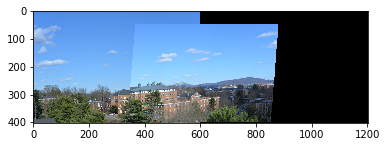

In [15]:
import skimage, skimage.transform, numpy, numpy.linalg

def composite_warped(A, B, bestHom):
    "Warp images a and b to a's coordinate system using the homography H which maps b coordinates to a coordinates."
    out_shape = (A.shape[0], 2*A.shape[1])                               # Output image (height, width)
    p = skimage.transform.ProjectiveTransform(numpy.linalg.inv(H))       # Inverse of homography (used for inverse warping)
    bwarp = skimage.transform.warp(B, p, output_shape=out_shape)         # Inverse warp b to a coords
    bvalid = numpy.zeros(B.shape, 'uint8')                               # Establish a region of interior pixels in b
    bvalid[1:-1,1:-1,:] = 255
    bmask = skimage.transform.warp(bvalid, p, output_shape=out_shape)    # Inverse warp interior pixel region to a coords
    apad = numpy.hstack((skimage.img_as_float(A), numpy.zeros(A.shape))) # Pad a with black pixels on the right
    return skimage.img_as_ubyte(numpy.where(bmask==1.0, bwarp, apad))    # Select either bwarp or apad based on mask

done = composite_warped(A, B, bestHom)
done = done[:,:,::-1] 
pylab.imshow(done)

In [36]:
print bestHom

[[  3.30000000e-01  -6.30000000e-01   3.88560000e+02]
 [ -9.00000000e-02  -5.00000000e-02   1.93240000e+02]
 [ -0.00000000e+00  -0.00000000e+00   1.00000000e+00]]
